## Question #1
$\frac{d^2T}{dx^2} + \frac{Q}{k}(T^3-T_a^3) = 0 $

#### BCs 
- T(x = 0) = 600 K 
- T(x = L ) = 400 K 
- L = 10 m 
- Q = $2*10^5 W/m^3$
- k = 50 W/m.K

Converged in 7 iterations.


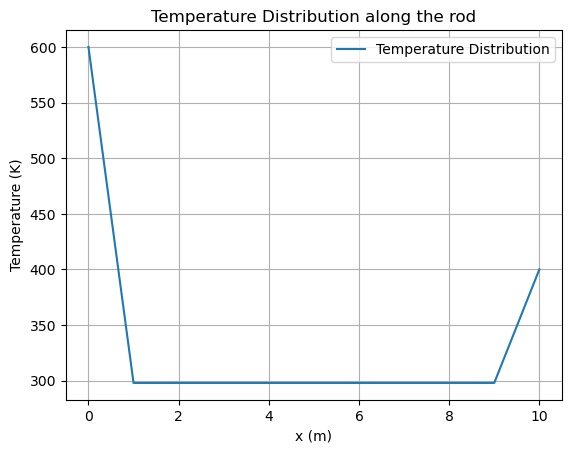

Temperature at x = 7 m: 298.00 K


In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
L = 10      # length in meters
N = 10    # number of grid points
Q = 2e5     # W/m^3
k = 50      # W/m.K
Ta = 298    # ambient temperature in K
T0 = 600    # boundary condition at x = 0
TN = 400    # boundary condition at x = L
dx = L / N  # step size

# Discretization
x = np.linspace(0, L, N+1)

# Define the system of equations for interior points only
def system(T_interior):
    dTdx2 = np.zeros(N-1)  # Only for interior points (N-1)
    
    # Include boundary conditions for finite difference calculations
    T_full = np.concatenate(([T0], T_interior, [TN]))  # Full temperature array with boundaries

    # Apply finite difference for interior points (1 to N-1)
    for i in range(1, N):
        dTdx2[i-1] = (T_full[i-1] - 2*T_full[i] + T_full[i+1]) / dx**2 + (Q/k) * (T_full[i]**3 - Ta**3)
    
    return dTdx2

# Define the Jacobian of the system
def jacobian(T_interior):
    J = np.zeros((N-1, N-1))
    T_full = np.concatenate(([T0], T_interior, [TN]))  # Full temperature array with boundaries
    
    # Calculate the Jacobian for each interior point
    for i in range(1, N):
        # Derivative with respect to T[i]
        J[i-1, i-1] = -2/dx**2 + (3 * Q / k) * T_full[i]**2
        
        # Derivative with respect to T[i-1]
        if i > 1:
            J[i-1, i-2] = 1/dx**2
            
        # Derivative with respect to T[i+1]
        if i < N-1:
            J[i-1, i] = 1/dx**2
    
    return J

def gaussian_elimination(A, b):
    n = len(b)
    
    # Forward Elimination
    for i in range(n):
        # Make the diagonal element 1 and eliminate the column below
        for j in range(i+1, n):
            factor = A[j][i] / A[i][i]
            b[j] -= factor * b[i]
            for k in range(i, n):
                A[j][k] -= factor * A[i][k]
    
    # Backward Substitution
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = b[i]
        for j in range(i+1, n):
            x[i] -= A[i][j] * x[j]
        x[i] /= A[i][i]
    
    return x

# Newton-Raphson Method
def newton_raphson(T_initial, tol=1e-6, max_iter=100):
    T_current = T_initial
    for iteration in range(max_iter):
        F_current = system(T_current)
        J_current = jacobian(T_current)
        
        # Solve J * delta_T = -F
        delta_T = gaussian_elimination(J_current.copy(), -F_current.copy())
        
        # Update the guess
        T_current += delta_T
        
        # Check for convergence
        if np.linalg.norm(delta_T) < tol:
            print(f'Converged in {iteration+1} iterations.')
            return T_current
        
    print('Did not converge.')
    return T_current

# Initial guess (linear interpolation between boundary conditions)
T_initial = np.linspace(T0, TN, N+1)[1:-1]  # Exclude boundary points

# Solve the system using the manual Newton-Raphson method
T_solution_interior = newton_raphson(T_initial)

# Include boundary conditions in the full solution
T_solution = np.zeros(N+1)
T_solution[0] = T0  # Left boundary
T_solution[1:-1] = T_solution_interior  # Interior points
T_solution[-1] = TN  # Right boundary

# Plot the solution
plt.plot(x, T_solution, label='Temperature Distribution')
plt.xlabel('x (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution along the rod')
plt.grid(True)
plt.legend()
plt.show()

# Interpolation at x = 7 m
x_target = 7  # The location where we want to find the temperature
# Find the two closest grid points
i_left = int(np.floor(x_target / dx))
i_right = i_left + 1

# Perform linear interpolation
T_7m = T_solution[i_left] + (x_target - x[i_left]) * (T_solution[i_right] - T_solution[i_left]) / (x[i_right] - x[i_left])

print(f'Temperature at x = 7 m: {T_7m:.2f} K')


### Dimensional Analysis of the Problem 
- $\left[\frac{Q}{k}\right] = K/m^2$

The value of C(0) that satisfies the boundary condition is: 0.100843
The concentration at r = 0.5 is: 0.100632


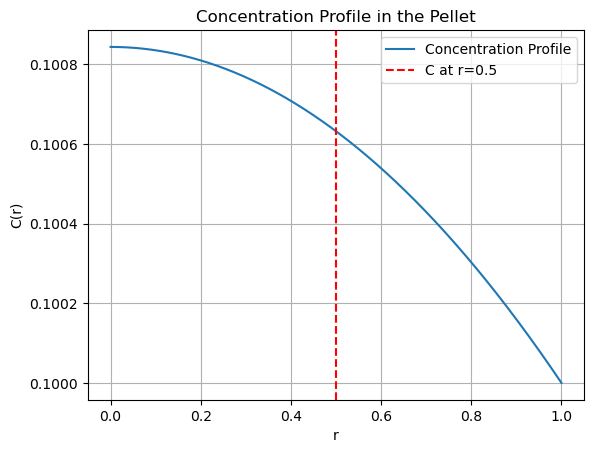

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
k = 0.5  # Reaction rate constant
n = 2  # Reaction order
r0 = 0.0  # Inner radius
r1 = 1.0  # Outer radius
C_boundary_r1 = 0.1  # Boundary condition at r = 1 (C = 0.1)
tol = 1e-6  # Tolerance for shooting method
h = 0.001  # Step size for Runge-Kutta

# Define the system of ODEs (converts second order to two first-order ODEs)
def odes(r, y, k, n):
    y1, y2 = y  # y1 = C(r), y2 = dC/dr
    if r == 0:
        return np.array([y2, 0])  # Handle the singularity at r = 0
    else:
        return np.array([y2, -(2 / r) * y2 - k * y1**n])

# Implementing the Runge-Kutta (RK4) method
def runge_kutta_step(r, y, h, k, n):
    k1 = h * odes(r, y, k, n)
    k2 = h * odes(r + 0.5*h, y + 0.5*k1, k, n)
    k3 = h * odes(r + 0.5*h, y + 0.5*k2, k, n)
    k4 = h * odes(r + h, y + k3, k, n)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6

# Solve the ODE from r0 to r1 using Runge-Kutta method
def solve_bvp(C0_guess):
    y = np.array([C0_guess, 0.0])  # Initial conditions: [C(r0), dC/dr at r0]
    r = r0
    while r < r1:
        y = runge_kutta_step(r, y, h, k, n)
        r += h
    return y[0]  # Return C at r1 (the last value)

# Use the shooting method to find C(0) that satisfies the boundary condition at r = 1
def shooting_method():
    C0_low = 0.0  # Lower guess for C(0)
    C0_high = 1.0  # Higher guess for C(0)
    
    while True:
        # Midpoint guess for C(0)
        C0_guess = (C0_low + C0_high) / 2
        
        # Solve the BVP for this guess
        C_at_r1 = solve_bvp(C0_guess)
        
        # Check if the boundary condition at r = 1 is satisfied
        if abs(C_at_r1 - C_boundary_r1) < tol:
            return C0_guess
        
        # Adjust the guess based on the result
        if C_at_r1 > C_boundary_r1:
            C0_high = C0_guess
        else:
            C0_low = C0_guess

# Run the shooting method to find C(0)
C0_solution = shooting_method()

# Output the result
print(f"The value of C(0) that satisfies the boundary condition is: {C0_solution:.6f}")

# Now to solve the ODE and get the entire profile
def get_concentration_profile(C0_solution):
    y = np.array([C0_solution, 0.0])  # Initial conditions
    r = r0
    r_values = []
    C_values = []
    
    while r < r1:
        r_values.append(r)
        C_values.append(y[0])
        y = runge_kutta_step(r, y, h, k, n)
        r += h
    
    r_values.append(r1)
    C_values.append(y[0])  # Final point at r = r1
    
    return np.array(r_values), np.array(C_values)

# Get the concentration profile
r_values, C_values = get_concentration_profile(C0_solution)

# Determine the concentration at r = 0.5
r_target = 0.5
C_at_r_target = np.interp(r_target, r_values, C_values)
print(f"The concentration at r = 0.5 is: {C_at_r_target:.6f}")

# Plot the concentration profile
plt.plot(r_values, C_values, label="Concentration Profile")
plt.axvline(x=r_target, color='r', linestyle='--', label=f"C at r={r_target}")
plt.xlabel('r')
plt.ylabel('C(r)')
plt.title('Concentration Profile in the Pellet')
plt.grid(True)
plt.legend()
plt.show()
